In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(16, 4.2)

from util import util_ctrp as util
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# Loading data
tr, val, ts = util.load_restaurant_data()
dt_in = tr.columns[:-1]

# Standardization of numerical attributes
nf = ['avg_rating', 'num_reviews']
scale = tr[nf].max()
tr_s = tr.copy()
tr_s[nf] = tr_s[nf] / scale
val_s = val.copy()
val_s[nf] = val_s[nf] / scale
ts_s = ts.copy()
ts_s[nf] = ts_s[nf] / scale

# One-hot encoding for the categorical attributes
tr_sc = pd.get_dummies(tr_s).astype(np.float32)
val_sc = pd.get_dummies(val_s).astype(np.float32)
ts_sc = pd.get_dummies(ts_s).astype(np.float32)
dt_in_c = [c for c in tr_sc.columns if c != 'clicked']

# Categorial encoding for the dollar rating
tr_sc2 = tr_s.copy()
tr_sc2['dollar_rating'] = tr_sc2['dollar_rating'].astype('category')
tr_sc2['dollar_rating'] = tr_sc2['dollar_rating'].cat.codes

val_sc2 = val_s.copy()
val_sc2['dollar_rating'] = val_sc2['dollar_rating'].astype('category').cat.codes

ts_sc2 = ts_s.copy()
ts_sc2['dollar_rating'] = ts_sc2['dollar_rating'].astype('category').cat.codes

# Paramters for the lattice model
data = tr_sc2
lattice_sizes = [2] * 3
attribute_names = ['avg_rating', 'num_reviews', 'dollar_rating']
calibration_types = ['numeric', 'numeric', 'categorical']
calibration_sizes = [20, 20, 4]

2024-01-24 14:01:49.910226: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-24 14:01:49.963392: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 14:01:49.963434: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 14:01:49.963466: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 14:01:49.970777: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-24 14:01:49.971424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Domain Knowledge in<br> Click-Through Rate Prediction

### Introducing the Problem

## Click-Through Rate Prediction

**Let's revisit our click-through rate prediction problem**

The use case was about a Tripadvisor-like system

* Given information about restaurants
* and about where users clicked or not on the restaurant cards
* Our goal is to estimate the probability of clicking

In [2]:
tr.iloc[:4]

,avg_rating,num_reviews,dollar_rating,clicked
0,3.927976,122.0,DDDD,1
1,3.927976,122.0,DDDD,0
2,3.927976,122.0,DDDD,0
3,4.329771,122.0,DDDD,1


**The intention is to _replace_ the current recommendation algorithm with a better one**

## Data Distribution

**We already inspected the distributon of the _training data_**

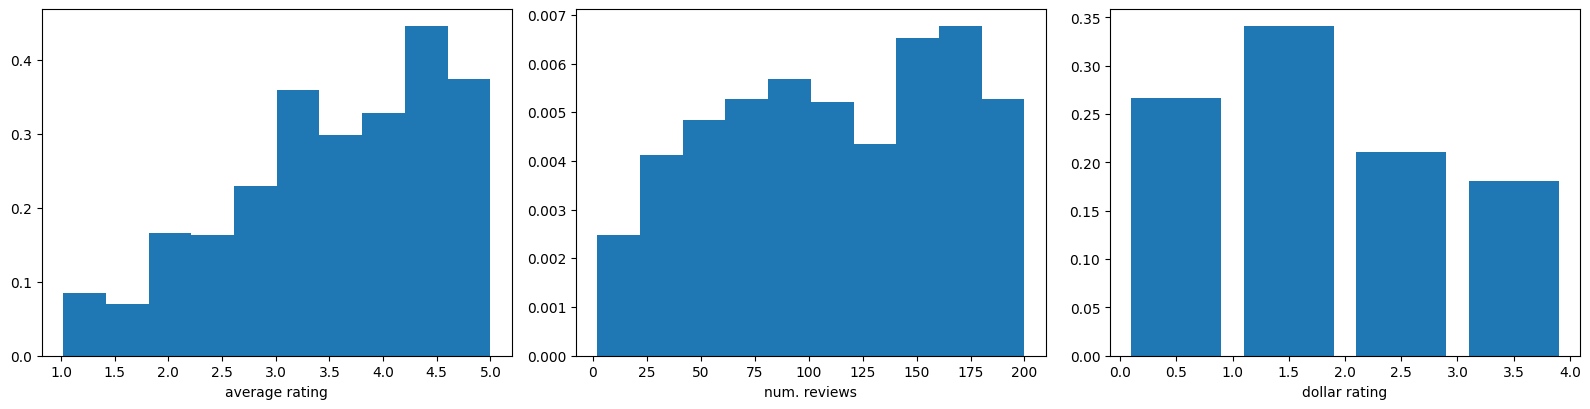

In [3]:
util.plot_ctr_distribution(tr, figsize=figsize, nbins=10)

* ...But mentioned that we cheated a bit in our evaluation
* In particular, we used for testing data that was actually _meant for validation_


## Data Distribution

**We will now look at the actual _test_ data**

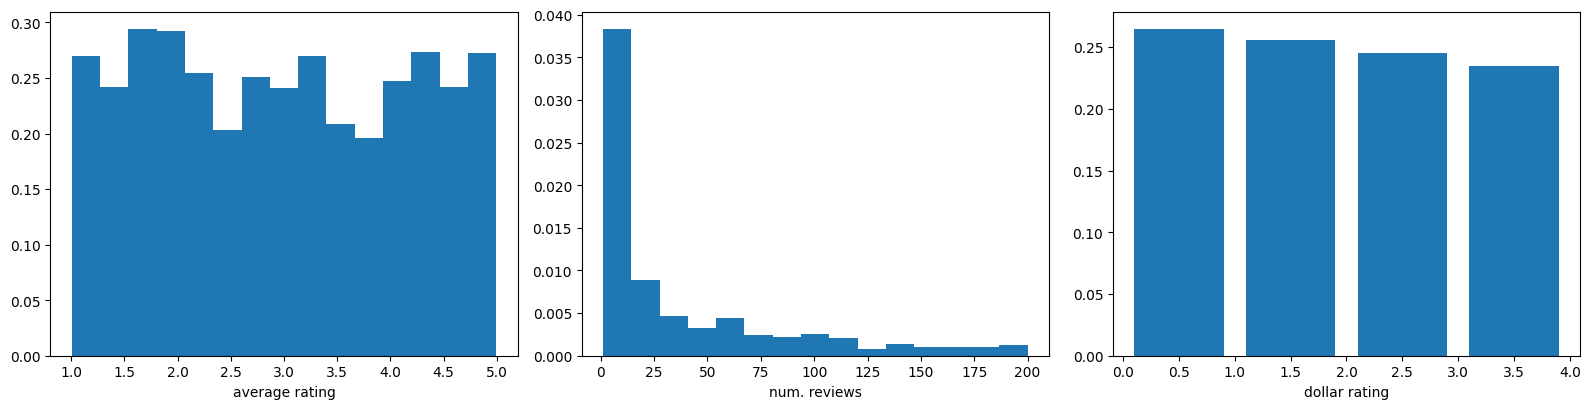

In [4]:
util.plot_ctr_distribution(ts, figsize=figsize)

The distribution is _significantly different_ from the training one!

**Why do you think is this the case?**

## Selection Bias

**The reason is _selection bias_**

* The training data comes from the current recommendation algorithm
* ...Which tends to _strongly favor_ certain restaurants w.r.t. others

So, middle priced, well-rated restaurants appear to be over-represented

**Selection bias is a very common issue**

It tends to arise whenever there is a decision process in place:

* Recommendation systems
* Marketing
* Organ transplant programs
* Operation of industrial machines

## Countering Selection Bias

**Countering selection bias is _not easy_**

* There are _a few_ available approaches
* ...But they all assume (some) knowledge of the _real world_ test distribution
* ...Which in many cases is not directly accessible

**This often an underestimated issue in ML**

* It's well know that the _training data_ should be representative of the _test data_
* ...But's even more important that the _test data_ is representative of the _real world_ data

**In our case study, we are in controlled conditions**

* This means we have access to the test data for the real world distribution
* ...And we'll be able to check how well one particular technique can work

## Test Performance of Our Previous Solution

**Let's check tbe "real world" performance of our previous solution**

First, we tr-train our 3-layer neural network

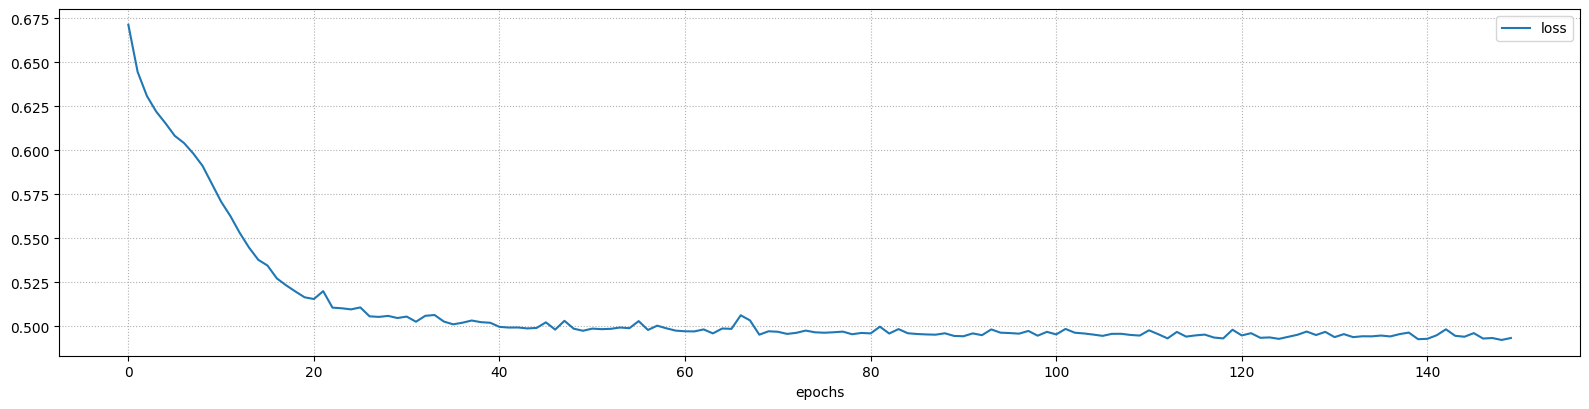

Final loss: 0.4935 (training)


In [5]:
nn = util.build_nn_model(input_shape=len(dt_in_c), output_shape=1, hidden=[16, 8, 8], output_activation='sigmoid')
history = util.train_nn_model(nn, tr_sc[dt_in_c], tr_sc['clicked'], loss='binary_crossentropy', batch_size=32, epochs=150)
util.plot_training_history(history, figsize=figsize, display_loss_curve=True)

## Test Performance of Our Previous Solution

**Then we check again its performance in terms of ROC-AUC**

In [6]:
pred_tr = nn.predict(tr_sc[dt_in_c], verbose=0)
pred_val = nn.predict(val_sc[dt_in_c], verbose=0)
pred_ts = nn.predict(ts_sc[dt_in_c], verbose=0)
auc_tr = roc_auc_score(tr_sc['clicked'], pred_tr)
auc_val = roc_auc_score(val_sc['clicked'], pred_val)
auc_ts = roc_auc_score(ts_sc['clicked'], pred_ts)
print(f'AUC score: {auc_tr:.2f} (training), {auc_val:.2f} (validation), {auc_ts:.2f} (test)')

AUC score: 0.81 (training), 0.81 (validation), 0.77 (test)


* The model is performing well on botht the training and validation data
* ...But there is a significant performance drop when moving to the test data

> **How can we mitigate this, given that the test data is not really accessible?**

# Domain Knowledge in<br> Click-Through Rate Prediction

### Mitigating Selection Bias via Domain Knowledge

## Ground Truth Click-Through Rate

**Let's check again the ground-truch click through rate**

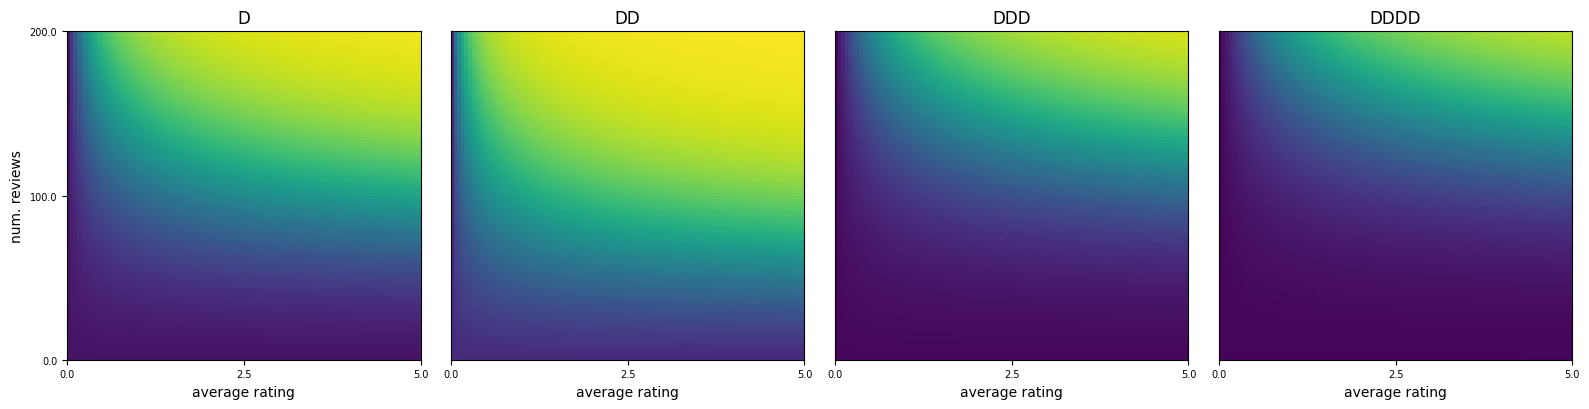

In [7]:
util.plot_ctr_truth(figsize=figsize)

**A domain expert may have several expectations on this function**

* E.g. `average rating` and `num. reviews` _cannot decrease_ the click-through rate

## Checking the Learned Response Surfaces

**There is not guarantee that the learned response surface satisfies these properties**

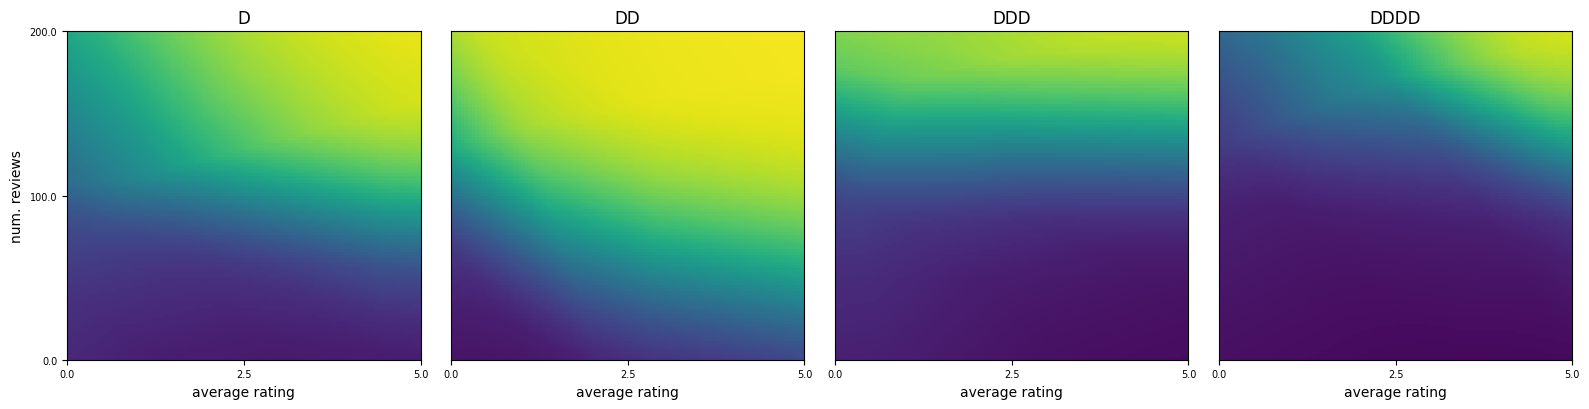

In [8]:
util.plot_ctr_estimation(nn, scale, figsize=figsize)

* In fact, there is a good chance that the model we've just learned
* ...Is violating a little or a lot a few of the expected monotonicities

## Domain Knowledge in Machine Learning

**The monotonic relations we mentioned are a form of _domain knowledge_**

...Which can be used for a variety of purposes

* We can use it to _improve generalization_ and counter selection bias
* ...Or we can use it to compensate for a _lack of data_
* ...Or to accomplish more with _smaller models_
* ...Or to allow a human to nudge some _control_ over the model behavior

**The best is that domain knowledge is _widespread_ in industrial settings**

After all, people have been doing their jobs for years without data-driven AI

* It would be very naïve to discard all the knowledge accumulated in the process
* ...And even more naïve to discard human contribution to an activity

When addressing a problem, _all available resources_ should be employed

## Domain Knowledge and Constraints

**There are multiple ways to take into account domain knowledge in ML**

Here we will focus on _one particular approach_

* If we are quite sure about our assumptions on the test distributions
* ...We can view them as _constraints_ on the model

In practice, we try to learn a model that _satisfies certain restrictions_

**The ability of constraining ML models is not well known**

...But it is _fairly widespread_! However:

* There are restrictions on which models and constraints can be used
* Adding constriant makes training more difficult
* ...And if the constraints are not well chosen it may hurt the model quality

## Our Constraints

**Our constraints can be though as _monotonicities_**

* We know that the average rating should have a monotonic effect on the click-through rate
* ...And the same holds for the number of reviews

We will assume that our domain expert knows one more fact:

* Averaged-price restaurant ar typically preferred to expensive ones

**Monotonicities are frequently encountered and seem simple**

...But they are among the _trickiest_ constraints to enforce

* They involve multiple examples, since they are based on comparisons
* They ideally should hold on all data, including unseen examples

As a result, only _very few_ ML model types support them

# Domain Knowledge in<br> Click-Through Rate Prediction

### Lattice Models

## Lattice Models

**_Lattice models_ are among the few that can fully support monotonicity constraints**

<center><img src="assets/lattice.png" width=30%/></center>

* They are defined via _a grid_ over their input variables
* Their parameters are _the output values at each grid point_
* The output values for input vectors not corresponding to a point of the grid...
* ...Is the _linear interpolation of neighboring grid points_

## Lattice Model

**Lattice models share some advantages with other ML models**


* Like other ML models they can learn arbitrarily complex input/output relations
* They can be trained with the same algorithms used for Neural Networks

**...But they are also easy to _interpret_**

* Their parameters represent _output values for certain input vectors_
* They can be changed with _predictable effects_
* They can be _constrained_ so that the model behaves in a desired fashion

**As a drawback, lattice model have scalability issues**

* They cannot be used directly for high-dimensional data
* ...Though they can appear as building block of more complex models

## Constraints in Lattice Models

**For sake of simplicity, let's consider a one-dimensional lattice**

* The lattice will have one parameter $\theta_k$ for every grid point
* The parameter corresponds to the output value for the grid point

**Then (increasing) _monotonicity_ translates to:**
$$
\theta_{k} \leq \theta_{k+1}
$$

* I.e. the output value at must be non-decreasing on the grid points
* The formulation can be extended to lattices with multiple inputs

**Other constraints can be formulated in the same fashion**

* E.g. convexity/concavity
* E.g. monotonicity between a subset of grid points

## Defining the Constraints

**Let's define the constraints on our model**

In [9]:
calibration_args = {}
calibration_args['avg_rating'] = {'monotonicity': 'increasing','kernel_regularizer': ('hessian', 0, 1)}

* On `avg_rating`, we require monotonicity

In [10]:
calibration_args['num_reviews'] = {'monotonicity': 'increasing', 'convexity': 'concave', 'kernel_regularizer': ('wrinkle', 0, 1)}

* On `num_reviews`, we require monotonicity and concavity

In [11]:
calibration_args['dollar_rating'] = {'monotonicities': [(0, 1), (3, 1)]}

* On `dollar_rating`, we require monotonicity between specific categories
* In particularm "`D`" and "`DDDD`" should have lower click-through rate than "`DD`"

## A Lattice Model for Our Problem

**Now we can build a lattice model for our problem**

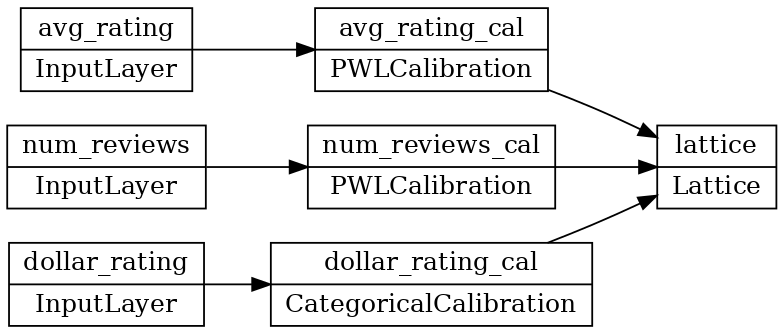

In [12]:
lm, cal_models = util.build_calibrated_lattice_model(tr_sc2, lattice_sizes, attribute_names, calibration_types, calibration_sizes, calibration_args)
util.plot_nn_model(lm, show_layer_activations=True, show_layer_names=True, show_shapes=False, dpi=130)

We are using a _combination of lattices_:

* We process every input through a _one-dimensional lattice_ (piecewise linear interpolation)
* We combined the transformed input through a _second lattice_

## Training the Lattice Model

**The lattice model can be trained as usual**

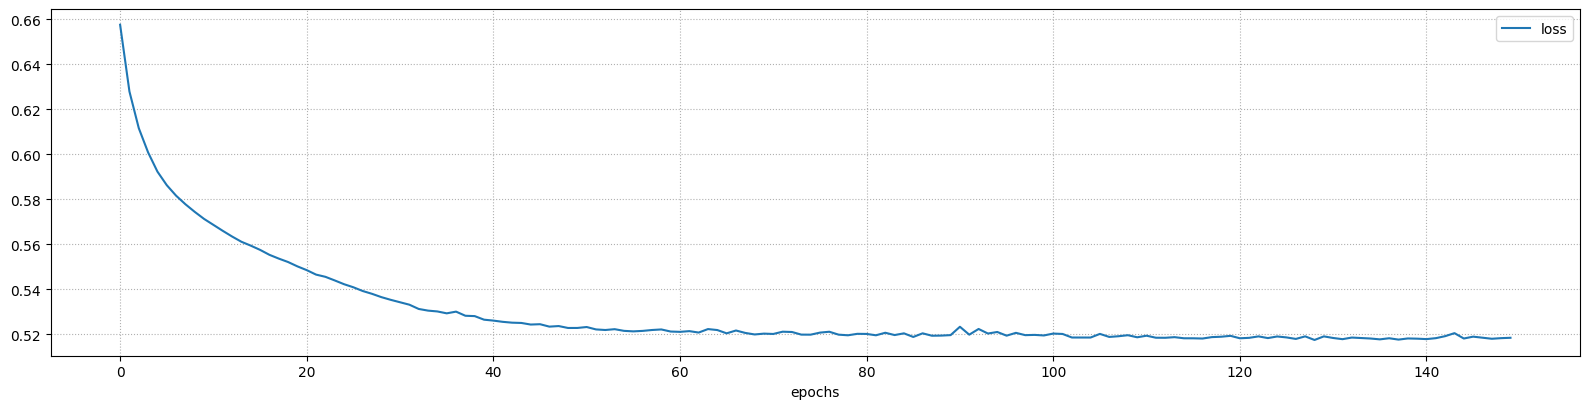

Final loss: 0.5183 (training)


In [13]:
tr_ls, val_ls, ts_ls = [tr_sc2[c] for c in dt_in], [val_sc2[c] for c in dt_in], [ts_sc2[c] for c in dt_in]
history = util.train_nn_model(lm, tr_ls, tr_sc['clicked'], loss='binary_crossentropy', batch_size=32, epochs=150, verbose=0)
util.plot_training_history(history, figsize=figsize)

## Evaluting the Model

**Let's evalute the performance of the model in terms of ROC-AUC**

In [14]:
pred_tr2 = lm.predict(tr_ls, verbose=0)
pred_val2 = lm.predict(val_ls, verbose=0)
pred_ts2 = lm.predict(ts_ls, verbose=0)
auc_tr2 = roc_auc_score(tr_s['clicked'], pred_tr2)
auc_val2 = roc_auc_score(val_s['clicked'], pred_val2)
auc_ts2 = roc_auc_score(ts_s['clicked'], pred_ts2)
print(f'AUC score: {auc_tr2:.2f} (training), {auc_val2:.2f} (validation), {auc_ts2:.2f} (test)')

AUC score: 0.80 (training), 0.81 (validation), 0.81 (test)


* The performance on the test data is now on part with the training one
* This is due partially to the constrainta
* ...And partially to the fact that the model is simpler
* ...And therefore at a lower risk of overfitting

## Inspecting the Model

**We can inspec the firs-stage (one dimensional) lattices**

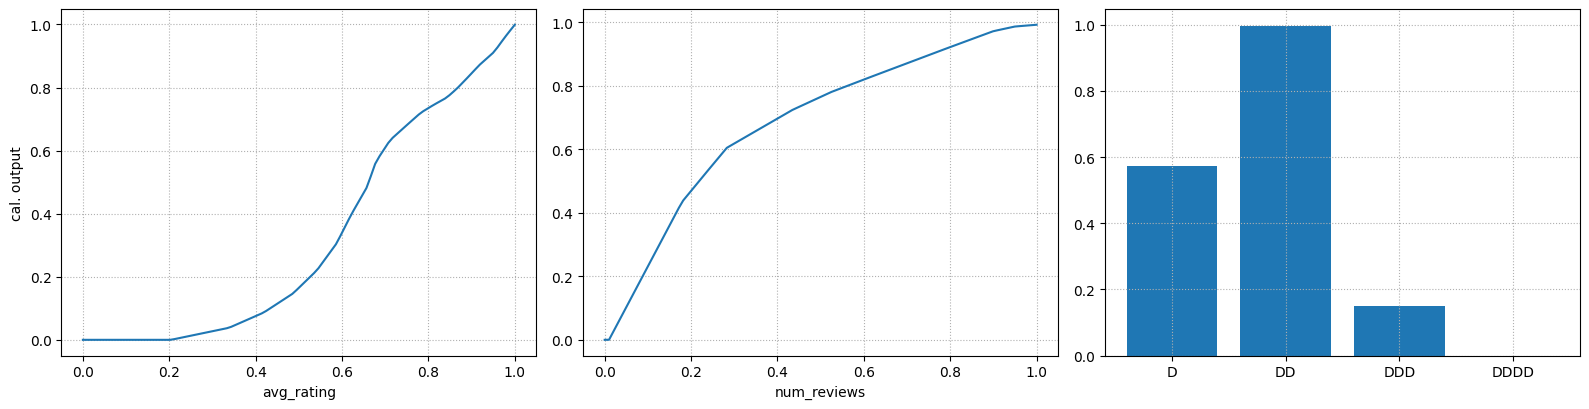

In [63]:
util.plot_ctr_calibration(cal_models, scale, figsize=figsize)

* As expected, all required monotonicities are respected

## Inspecting the Model

**The entire model also complies with the constraints**

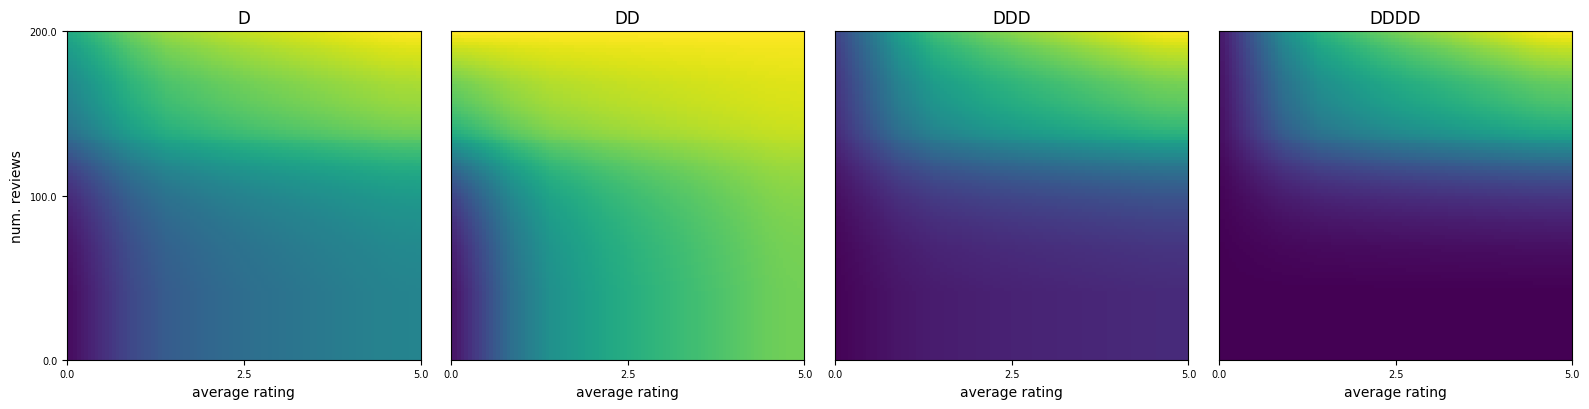

In [62]:
util.plot_ctr_estimation(lm, scale, split_input=True, one_hot_categorical=False, figsize=figsize)

* The tartan-like patter is caused by the fact that we first transform each input
* ...And the we use a relatively simple aggregation for the transformed inputs